# Data Augmentation using DCGANs #

Usecase: We leverage DCGAN model based on the original 2016 [Unsupervised Representation Learning with Deep Convolutional Generative Adversarial Networks](https://arxiv.org/abs/1511.06434) paper by Alec Radford et al., to perform data augmentation on a medical dataset like Chest X-ray Pneumonia dataset.

Chest X-ray Pneumonia dataset consistes of around 5,863 X-ray images.

DCGANs provide a significant improvement over vanilla GANs due to: 
- Inclusion of strided convolution layers instead of pooling layers, making it best for image generation applications
- Using tanh activation fn in the output layer for generator
- Leveraging LeakyReLu activation for all discriminator layers 
- Leveraging BatchNorm in both models 

**Generator-Discriminator Network**

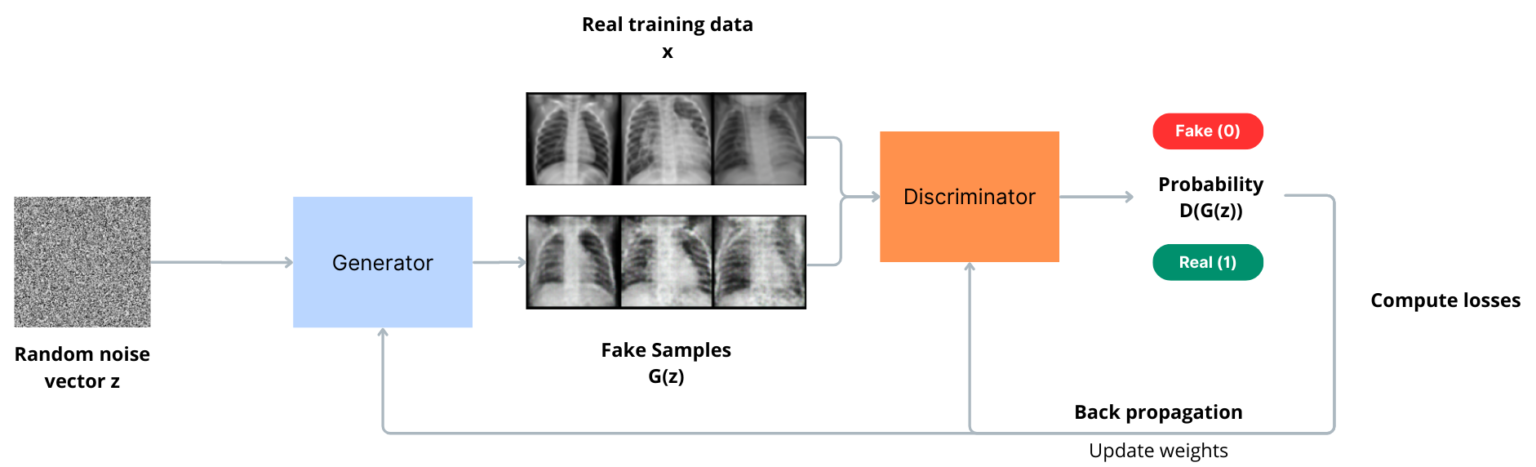

**Step 1:** Dataset loading and preprocessing

In [ ]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("paultimothymooney/chest-xray-pneumonia")

print("Path to dataset files:", path)

/home/sharon/anaconda3/envs/work38/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Path to dataset files: /home/sharon/.cache/kagglehub/datasets/paultimothymooney/chest-xray-pneumonia/versions/2


We have decided to go with flower image dataset from kagglehub for this project.

We can go ahead and move the dataset to the appropriate folder and set that path for dataloader.

Now we proceed with importing the dataset and training 

In [ ]:
# imports
import torch
import torch.nn as nn
import torch.optim as optim

import torchvision.utils as vutils

In [ ]:
# all the variables

netD = "checkpoints/netD.pth" # checkpoint path for discriminator
netG = "checkpoints/netG.pth" # checkpoint path for generator
dataroot = path + "/chest_xray/train" # dataset path
workers=2
batch_size = 128
image_size = 64
nc = 3 
nz = 100 # latent vector dimention, size of generator output
ngf = 64 # feature map size in generator
ndf = 64 # feature map size in discriminator
num_epochs = 20
lr = 0.0002
ngpu = 1 
save_every = 5 # save model checkpoint every 10 epochs
outputD = 'checkpoints/netD.pth'
outputG = 'checkpoints/netG.pth'
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device


device(type='cuda', index=0)

**Step 2:** Defining the Dataloader

In [ ]:
import torchvision.transforms as transforms
import torchvision.datasets as dset

# these are the transforms for better feature extraction
dataset = dset.ImageFolder(root=dataroot,
    transform=transforms.Compose(
        [
        transforms.Resize(image_size),
        transforms.CenterCrop(image_size),
        transforms.ToTensor(),
        transforms.Normalize(
            (0.5,0.5,0.5),
            (0.5, 0.5,0.5)
            )
        ]))

# setting up data loader
dataloader = torch.utils.data.DataLoader(dataset, 
    batch_size=batch_size,
    shuffle=True,
    num_workers=workers
    )

We can checkout sample data from the flower dataset

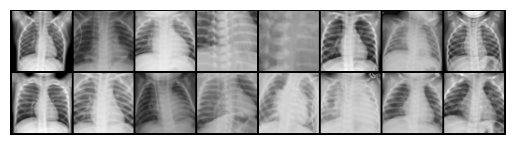

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
def imshow(img):
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.axis('off')
    plt.show()

# get a batch of real images
data_iter = iter(dataloader)
images, _ = next(data_iter) 

# create a grid from the batch to display 16 imgs
img_grid = vutils.make_grid(images[:16], padding=2, normalize=True) 

# display image
imshow(img_grid)

Model architecture

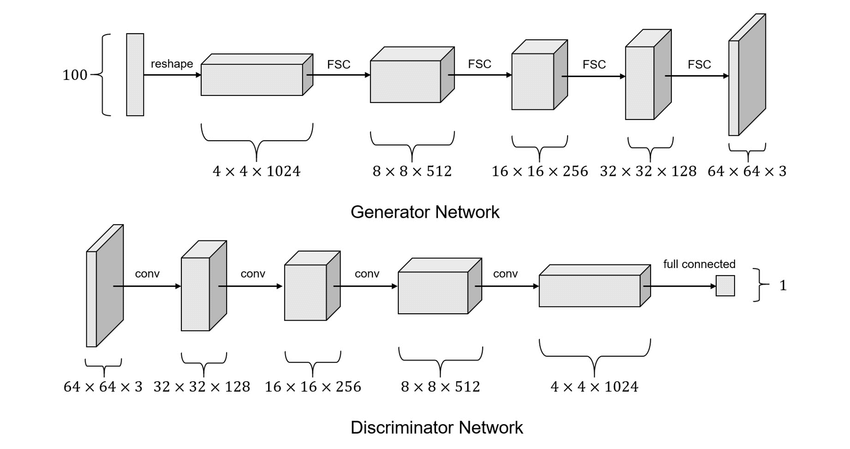


Defining the Generator class

In [ ]:
class Generator(nn.Module):
  def __init__(self):
    super(Generator, self).__init__()
    self.main = nn.Sequential(
        # we have input latent vector of shape (nz x 1 x 1), output would be (feature map*8 x 4 x 4) 
        nn.ConvTranspose2d(nz, ngf * 8, 4, 1, 0, bias=False),
        nn.BatchNorm2d(ngf * 8),
        nn.ReLU(True),
        
        # input: (feature map*8) x 4 x 4
        # output: (feature map*4) x 8 x 8
        nn.ConvTranspose2d(ngf * 8, ngf * 4, 4, 2, 1, bias=False),
        nn.BatchNorm2d(ngf*4),
        nn.ReLU(True),
        
        # Input: (feature map*4) x 8 x 8
        # Output: (feature map*2) x 16 x 16
        nn.ConvTranspose2d(ngf*4, ngf*2, 4, 2, 1, bias=False),
        nn.BatchNorm2d(ngf*2),
        nn.ReLU(True),
        
        # Input: (feature_map*2) x 16 x 16
        # Output: (feature_map_gen) x 32 x 32
        nn.ConvTranspose2d(ngf * 2, ngf, 4, 2, 1, bias=False),
        nn.BatchNorm2d(ngf),
        nn.ReLU(True),
        
        # Input: (feature_map) x 32 x 32
        # Output: (nc) x 64 x 64 (nc = number of channels)
        nn.ConvTranspose2d(ngf, nc, 4, 2, 1, bias=False),
        nn.Tanh() # Scale output to range [-1, 1] to match normalized real images
    )
    
  def forward(self, input):
    return self.main(input)

Defining the Discriminator

In [ ]:
class Discriminator(nn.Module):
  def __init__(self):
    super(Discriminator, self).__init__()
    self.main = nn.Sequential(
        # Input: (nc) x 64 x 64 (e.g., RGB image)
        # Output: (feature_map) x 32 x 32
        nn.Conv2d(nc, ndf, 4, 2, 1, bias=False),
        nn.LeakyReLU(0.2, inplace=True),
        
        # Input: (feature_map_dis) x 32 x 32
        # Output: (feature_map_dis*2) x 16 x 16
        nn.Conv2d(ndf, ndf *2, 4, 2, 1, bias=False),
        nn.BatchNorm2d(ndf *2),
        nn.LeakyReLU(0.2, inplace=True),
        
        # Input: (feature_map_dis*2) x 16 x 16
        # Output: (feature_map_dis*4) x 8 x 8
        nn.Conv2d(ndf * 2, ndf * 4, 4, 2, 1, bias=False),
        nn.BatchNorm2d(ndf * 4),
        nn.LeakyReLU(0.2, inplace=True),
        
        # Input: (feature_map_dis*4) x 8 x 8
        # Output: (feature_map_dis*8) x 4 x 4
        nn.Conv2d(ndf * 4, ndf * 8, 4, 2, 1, bias=False),
        nn.BatchNorm2d(ndf * 8),
        nn.LeakyReLU(0.2, inplace=True),
        
        # Input: (feature_map_dis*8) x 4 x 4
        # Output: 1 x 1 x 1 (probability score)
        nn.Conv2d(ndf * 8, 1, 4, 1, 0, bias=False),
        nn.Sigmoid()
    )
    
  def forward(self, input):
    return self.main(input)

here we define a fn to apply weight initialization to the model

In [10]:
def init_weights(m):
  classname = m.__class__.__name__
  if classname.find('Conv') != -1:
    nn.init.normal_(m.weight.data, 0.0, 0.02)
  
  elif classname.find('BatchNorm') != -1:
    nn.init.normal_(m.weight.data, 1.0, 0.02)
    nn.init.constant_(m.bias.data, 0)

In [29]:
# let's instantiate the model
generator_model = Generator().to(device)
discriminator_model = Discriminator().to(device)

# we apply the ``weights_init`` funb_channelstion to randomly initialize all weights
#  to ``mean=0``, ``stdev=0.02``.
generator_model.apply(init_weights)
discriminator_model.apply(init_weights)

print("Generator model architecture: ")
# Print the model
print(generator_model)

print("Discriminator model architecture: ")
# Print the model
print(discriminator_model)


Generator model architecture: 
Generator(
  (main): Sequential(
    (0): ConvTranspose2d(100, 512, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (4): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (7): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU(inplace=True)
    (9): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (10): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): ReLU(inplace=True)
    (12): ConvTranspose2d(64, 3, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias

Training loop

In [ ]:
def train(gen_model, dis_model):

	# setup up loss & optimizers
	criterion = nn.BCELoss()
	optimizerG = optim.Adam(gen_model.parameters(), lr=lr, betas=(0.5 , 0.999))
	optimizerD = optim.Adam(dis_model.parameters(), lr=lr, betas=(0.5 , 0.999))

	# For input of generator in testing
	random_sig = torch.randn(64, nz, 1, 1, device=device)

	# convention for training
	real_label = 1.0
	fake_label = 0.0

	# training data for later analysis
	img_list= []
	generator_losses = []
	discriminator_losses = []

	# For each epoch
	for e in range(num_epochs):
		# for each batch in the dataloader
			for i, data in enumerate(dataloader, 0):
				# Training Discriminator
				dis_model.zero_grad()

				# train with real data
				real_data = data[0].to(device)

				# make labels
				batch_size = real_data.size(0)
				labels = torch.full((batch_size,), real_label, device=device)

				# forward pass real data through D
				real_outputD = dis_model(real_data).view(-1)

				# calc error on real data
				errD_real = criterion(real_outputD, labels)

				# calc grad
				errD_real.backward()
				D_x = real_outputD.mean().item()

				# train with fake data
				noise = torch.randn(batch_size, nz, 1, 1, device=device)
				fake_data = gen_model(noise)
				labels.fill_(fake_label)

				# classify fake
				fake_outputD = dis_model(fake_data.detach()).view(-1)

				# calc error on fake data
				errD_fake = criterion(fake_outputD, labels)

				# calc grad
				errD_fake.backward()
				D_G_z1 = fake_outputD.mean().item()

				# add all grad and update D
				errD = errD_real + errD_fake
				optimizerD.step()

				# End of Discriminator training part 

				# Training Generator
				gen_model.zero_grad()

				# since aim is fooling the discriminator network, labels should be flipped
				labels.fill_(real_label)

				# forward pass with updated discriminator
				fake_outputD = dis_model(fake_data).view(-1)

				# calc error
				errG = criterion(fake_outputD, labels)

				# calc grad
				errG.backward()

				D_G_z2 = fake_outputD.mean().item()

				# update G
				optimizerG.step()

				# end of generator training

				# for later plot
				generator_losses.append(errG.item())
				discriminator_losses.append(errD.item())

			print(f'Epoch:[{e+1}/{num_epochs}] \t Loss_D:{errD.item():.4f} \t Loss_G:{errG.item():.4f} \t D(x):{D_x:.4f} \t D(G(z)):{D_G_z1:.4f}/{D_G_z2:.4f}')
			if (e+1)%save_every==0:
				# save at args.save_every epoch
				torch.save(gen_model.state_dict(), outputG)
				torch.save(dis_model.state_dict(), outputD)
				# generate a fake img with the trained checkpoint so far
				with torch.no_grad():
						fake = gen_model(random_sig).detach().cpu()
						img_list.append(vutils.make_grid(fake, padding=2, normalize=True))
						plt.figure(figsize=(3, 3))
						plt.axis("off")
						plt.imshow(np.transpose(img_list[-1], (1, 2, 0)))
						plt.show()
				print(f'Made a New Checkpoint for {e+1}')

	torch.save(gen_model.state_dict(), outputG)
	torch.save(dis_model.state_dict(), outputD)
	print(f'Saved Final model at {outputG} & {outputD}')
	# return training data for analysis
	return img_list, generator_losses, discriminator_losses

Epoch:[1/20] 	 Loss_D:0.1599 	 Loss_G:34.1015 	 D(x):0.9447 	 D(G(z)):0.0000/0.0000
Epoch:[2/20] 	 Loss_D:0.0003 	 Loss_G:30.6330 	 D(x):0.9997 	 D(G(z)):0.0000/0.0000
Epoch:[3/20] 	 Loss_D:0.0000 	 Loss_G:39.3562 	 D(x):1.0000 	 D(G(z)):0.0000/0.0000
Epoch:[4/20] 	 Loss_D:0.0000 	 Loss_G:39.0093 	 D(x):1.0000 	 D(G(z)):0.0000/0.0000
Epoch:[5/20] 	 Loss_D:0.0002 	 Loss_G:37.9946 	 D(x):0.9998 	 D(G(z)):0.0000/0.0000


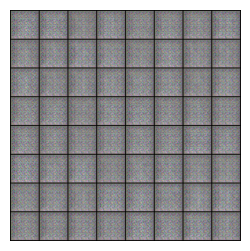

Made a New Checkpoint for 5
Epoch:[6/20] 	 Loss_D:0.2484 	 Loss_G:7.9281 	 D(x):0.8693 	 D(G(z)):0.0066/0.0020
Epoch:[7/20] 	 Loss_D:0.6346 	 Loss_G:4.7619 	 D(x):0.7798 	 D(G(z)):0.2364/0.0143
Epoch:[8/20] 	 Loss_D:0.6920 	 Loss_G:3.3489 	 D(x):0.7300 	 D(G(z)):0.1915/0.0576
Epoch:[9/20] 	 Loss_D:1.8367 	 Loss_G:7.1174 	 D(x):0.9050 	 D(G(z)):0.7672/0.0043
Epoch:[10/20] 	 Loss_D:0.8123 	 Loss_G:2.2557 	 D(x):0.7016 	 D(G(z)):0.3017/0.1517


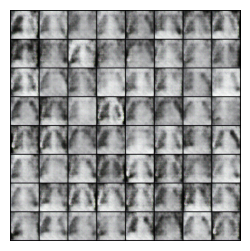

Made a New Checkpoint for 10
Epoch:[11/20] 	 Loss_D:1.2867 	 Loss_G:3.9466 	 D(x):0.9169 	 D(G(z)):0.6354/0.0425
Epoch:[12/20] 	 Loss_D:0.8256 	 Loss_G:1.9952 	 D(x):0.5932 	 D(G(z)):0.0866/0.1794
Epoch:[13/20] 	 Loss_D:0.7140 	 Loss_G:2.2046 	 D(x):0.6894 	 D(G(z)):0.2124/0.1724
Epoch:[14/20] 	 Loss_D:0.6887 	 Loss_G:4.3313 	 D(x):0.8189 	 D(G(z)):0.3190/0.0255
Epoch:[15/20] 	 Loss_D:0.9725 	 Loss_G:2.1399 	 D(x):0.5028 	 D(G(z)):0.0302/0.1795


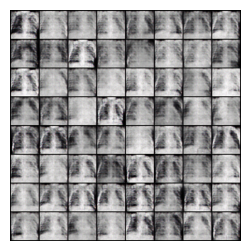

Made a New Checkpoint for 15
Epoch:[16/20] 	 Loss_D:0.5668 	 Loss_G:3.1366 	 D(x):0.7544 	 D(G(z)):0.2051/0.0669
Epoch:[17/20] 	 Loss_D:0.7309 	 Loss_G:5.1287 	 D(x):0.8371 	 D(G(z)):0.3758/0.0119
Epoch:[18/20] 	 Loss_D:0.3497 	 Loss_G:4.5049 	 D(x):0.8046 	 D(G(z)):0.0994/0.0317
Epoch:[19/20] 	 Loss_D:0.6095 	 Loss_G:2.7009 	 D(x):0.7175 	 D(G(z)):0.1771/0.1020
Epoch:[20/20] 	 Loss_D:0.8981 	 Loss_G:5.8982 	 D(x):0.9212 	 D(G(z)):0.5027/0.0105


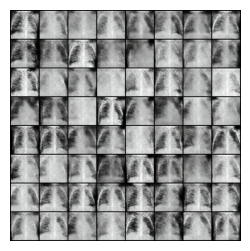

Made a New Checkpoint for 20
Saved Final model at checkpoints/netG.pth & checkpoints/netD.pth


In [31]:
img_list, generator_losses, discriminator_losses = train(generator_model, discriminator_model)

Let's plot loss graph's for the DCGAN

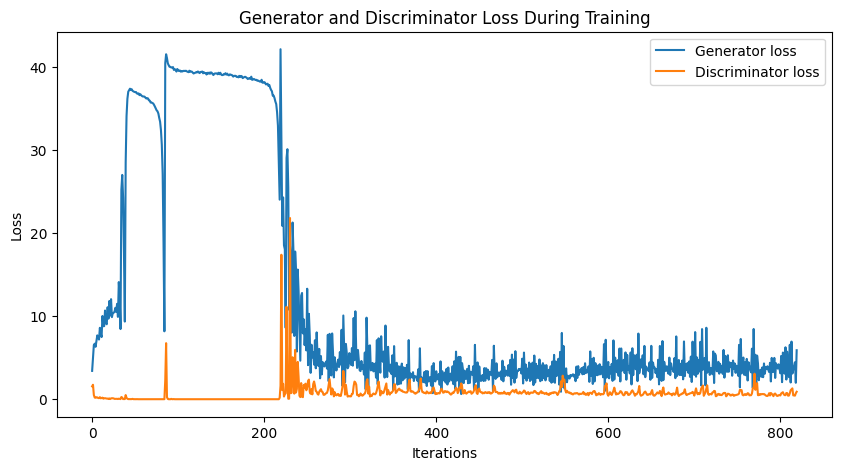

In [32]:
plt.figure(figsize=(10,5))
plt.title("Generator and Discriminator Loss During Training")
plt.plot(generator_losses,label="Generator loss")
plt.plot(discriminator_losses,label="Discriminator loss")
plt.xlabel("Iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()

Now let's do a demo and try to generate some fake images from the trained model 

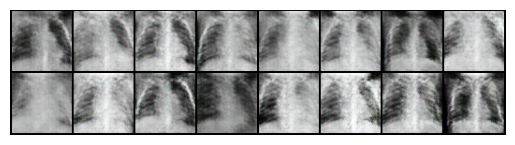

In [33]:
import matplotlib.pylab as plt
import numpy as np

device = torch.device('cuda:0' 
    if torch.cuda.is_available()  
    else 'cpu')

# load generator model
# trained_generator_net = Generator().to(device)
# trained_generator_net.load_state_dict(torch.load(outputG))

# let's try generating 1 image
n = 16
# create some random noise
noise = torch.randn(n, nz, 1, 1, device=device)
fake = generator_model(noise).detach().cpu()
img = vutils.make_grid(fake, padding=2, normalize=True)

# save image
plt.axis("off")
plt.imshow(np.transpose(img,(1,2,0)))
plt.savefig("output_images")

Now it's time to evaluate images and generate the required data to augment the Chest X-ray dataset. 

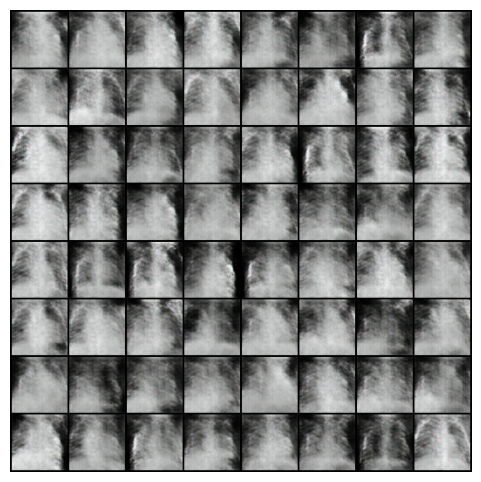

In [ ]:
# define minimum confidence score to consider an image as valid
confidence_cutoff = 0.70

# container for storing high-quality generated images
selected_images = []

# target count of valid images to gather
target_image_count = 64

while len(selected_images) < target_image_count:
    
    # generate random latent vectors as input for the generator
    latent_vectors = torch.randn(n, nz, 1, 1, device=device)
    
    # produce fake images from the generator
    with torch.no_grad():
        generated_batch = generator_model(latent_vectors)
        
        discriminator_model.eval()
        
        # evaluate the realism of generated images
        confidence_scores = discriminator_model(generated_batch)

    confidence_scores = confidence_scores.squeeze()

    # filter images that meet the confidence threshold
    high_confidence_mask = confidence_scores >= confidence_cutoff
    filtered_images = generated_batch[high_confidence_mask]

    # add accepted images to the selection pool
    if filtered_images.numel() > 0:
        for img in filtered_images:
            selected_images.append(img)

image_grid = vutils.make_grid(selected_images, nrow=8, padding=2, normalize=True).cpu()
image_grid = np.transpose(image_grid, (1, 2, 0))

plt.figure(figsize=(6, 6))
plt.imshow(image_grid)
plt.axis('off')
plt.show()


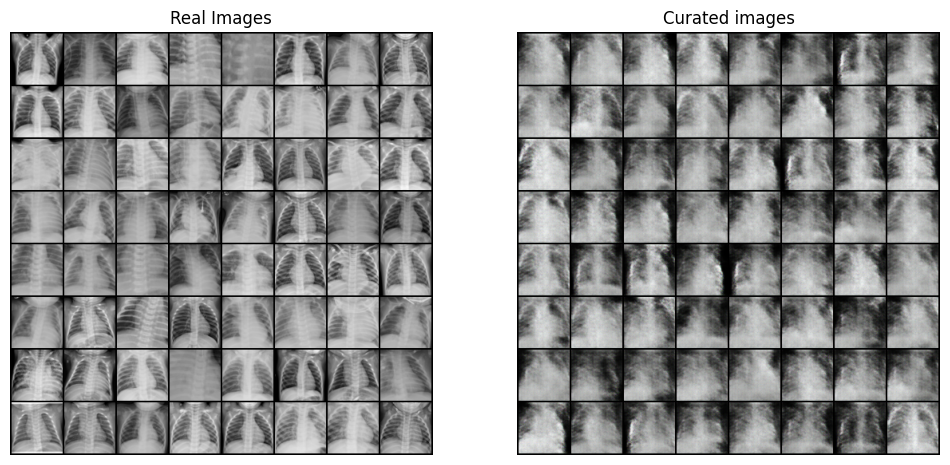

In [46]:
# Real images
plt.figure(figsize=(12, 12))
plt.subplot(1, 2, 1)
plt.axis("off")
plt.title("Real Images")
img_real = vutils.make_grid(images[:64], padding=2, normalize=True).cpu()
img_real = np.transpose(img_real, (1, 2, 0)) 
plt.imshow(img_real)

# Fake images
img_grid = vutils.make_grid(selected_images, padding=2, normalize=True).cpu()
img_grid = np.transpose(img_grid, (1, 2, 0))
plt.subplot(1,2,2)
plt.axis("off")
plt.title("Curated images")
plt.imshow(img_grid)

plt.show()